# BTC/USD Feature Engineering for ML

This notebook creates technical indicators and features from BTC/USD price data for machine learning models. We'll build a comprehensive feature set including momentum indicators, volatility measures, and price patterns.

## 1. Import Libraries and Load Data

Import required libraries and load the BTC/USD data from our EDA analysis.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime

# Try to import talib, but continue without it if not available
try:
    import talib
    TALIB_AVAILABLE = True
    print("✅ TA-Lib imported successfully!")
except ImportError:
    TALIB_AVAILABLE = False
    print("⚠️  TA-Lib not available - will use manual implementations")

# Set display options
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('default')

print("✅ Libraries imported successfully!")
print("📚 Features to be created:")
print("   - Moving Averages (SMA, EMA)")
print("   - Momentum Indicators (RSI, MACD, Stochastic)")
print("   - Volatility Measures (Bollinger Bands, ATR)")
print("   - Price Patterns (Support/Resistance, Candlestick)")
print("   - Volume Indicators (OBV, Volume SMA)")
print("   - Time-based Features (Hour, Day, etc.)")

⚠️  TA-Lib not available - will use manual implementations
✅ Libraries imported successfully!
📚 Features to be created:
   - Moving Averages (SMA, EMA)
   - Momentum Indicators (RSI, MACD, Stochastic)
   - Volatility Measures (Bollinger Bands, ATR)
   - Price Patterns (Support/Resistance, Candlestick)
   - Volume Indicators (OBV, Volume SMA)
   - Time-based Features (Hour, Day, etc.)


In [3]:
# Load BTC/USD data
file_paths = [
    '../data/BTCUSD_minute.csv',
    'data/BTCUSD_minute.csv', 
    './data/BTCUSD_minute.csv'
]

df = None
for file_path in file_paths:
    try:
        if Path(file_path).exists():
            df = pd.read_csv(file_path)
            print(f"✅ Data loaded from: {file_path}")
            break
    except Exception as e:
        continue

if df is None:
    print("❌ Could not find data file!")
else:
    # Prepare data
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    print(f"📊 Dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")
    print(f"📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"💰 Price range: ${df['Close'].min():,.0f} - ${df['Close'].max():,.0f}")
    
    # Create a copy for feature engineering
    features_df = df.copy()
    
    print("✅ Data prepared for feature engineering!")

✅ Data loaded from: ../data/BTCUSD_minute.csv
📊 Dataset: 28,100 rows, 12 columns
📅 Date range: 2025-06-30 15:44:00+00:00 to 2025-07-23 17:35:00+00:00
💰 Price range: $105,160 - $123,078
✅ Data prepared for feature engineering!


## 2. Moving Averages

Create Simple Moving Averages (SMA) and Exponential Moving Averages (EMA) for trend analysis.

📈 Creating Moving Averages...
✅ Created 29 moving average features


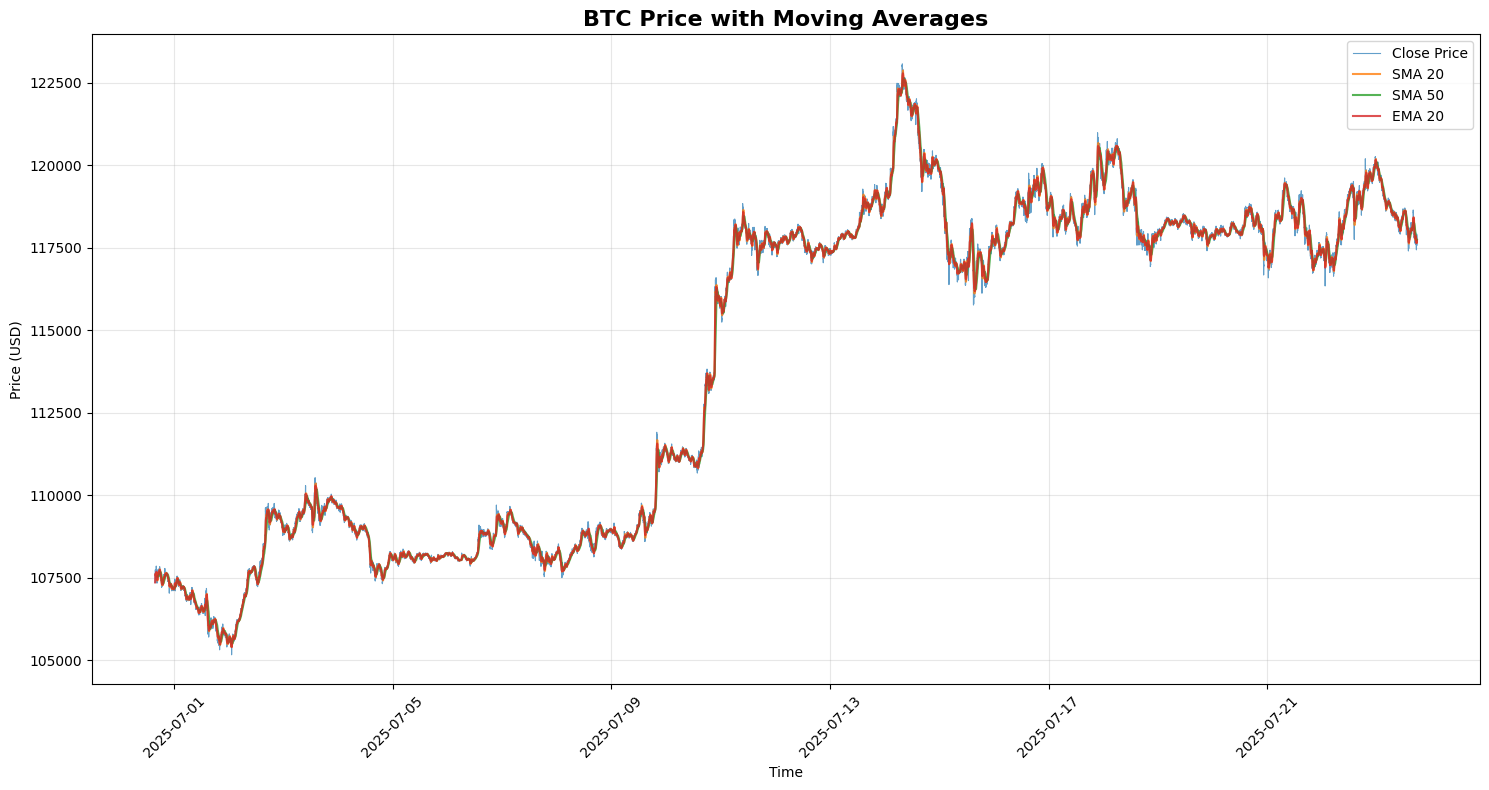


📊 Moving Average Summary:
   SMA_20: $117,668.39 (Above current price)
   EMA_20: $117,714.36 (Above current price)
   SMA_50: $117,742.10 (Above current price)
   EMA_50: $117,761.12 (Above current price)


In [4]:
# Create Moving Averages
print("📈 Creating Moving Averages...")

# Define periods for different timeframes
ma_periods = [5, 10, 20, 50, 100, 200]  # minutes

for period in ma_periods:
    # Simple Moving Average
    features_df[f'SMA_{period}'] = features_df['Close'].rolling(window=period).mean()
    
    # Exponential Moving Average
    features_df[f'EMA_{period}'] = features_df['Close'].ewm(span=period).mean()
    
    # Moving Average Ratios (price relative to MA)
    features_df[f'Price_SMA_{period}_Ratio'] = features_df['Close'] / features_df[f'SMA_{period}']
    features_df[f'Price_EMA_{period}_Ratio'] = features_df['Close'] / features_df[f'EMA_{period}']

# Moving Average Crossovers (trend signals)
features_df['SMA_5_20_Cross'] = (features_df['SMA_5'] > features_df['SMA_20']).astype(int)
features_df['SMA_10_50_Cross'] = (features_df['SMA_10'] > features_df['SMA_50']).astype(int)
features_df['EMA_5_20_Cross'] = (features_df['EMA_5'] > features_df['EMA_20']).astype(int)

# Moving Average Convergence/Divergence signals
features_df['SMA_5_20_Diff'] = features_df['SMA_5'] - features_df['SMA_20']
features_df['EMA_5_20_Diff'] = features_df['EMA_5'] - features_df['EMA_20']

print(f"✅ Created {len([col for col in features_df.columns if 'MA' in col or 'Cross' in col or 'Diff' in col])} moving average features")

# Visualize some key moving averages
plt.figure(figsize=(15, 8))
plt.plot(features_df['timestamp'], features_df['Close'], label='Close Price', alpha=0.7, linewidth=0.8)
plt.plot(features_df['timestamp'], features_df['SMA_20'], label='SMA 20', alpha=0.8)
plt.plot(features_df['timestamp'], features_df['SMA_50'], label='SMA 50', alpha=0.8)
plt.plot(features_df['timestamp'], features_df['EMA_20'], label='EMA 20', alpha=0.8)
plt.title('BTC Price with Moving Averages', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n📊 Moving Average Summary:")
for period in [20, 50]:
    current_price = features_df['Close'].iloc[-1]
    sma_val = features_df[f'SMA_{period}'].iloc[-1]
    ema_val = features_df[f'EMA_{period}'].iloc[-1]
    
    print(f"   SMA_{period}: ${sma_val:,.2f} ({'Above' if current_price > sma_val else 'Below'} current price)")
    print(f"   EMA_{period}: ${ema_val:,.2f} ({'Above' if current_price > ema_val else 'Below'} current price)")

## 3. Momentum Indicators

Create RSI, MACD, Stochastic Oscillator, and other momentum-based technical indicators.

⚡ Creating Momentum Indicators...
⚠️  Using manual indicator implementations...
✅ Manual indicators created successfully
✅ Created 13 momentum indicators


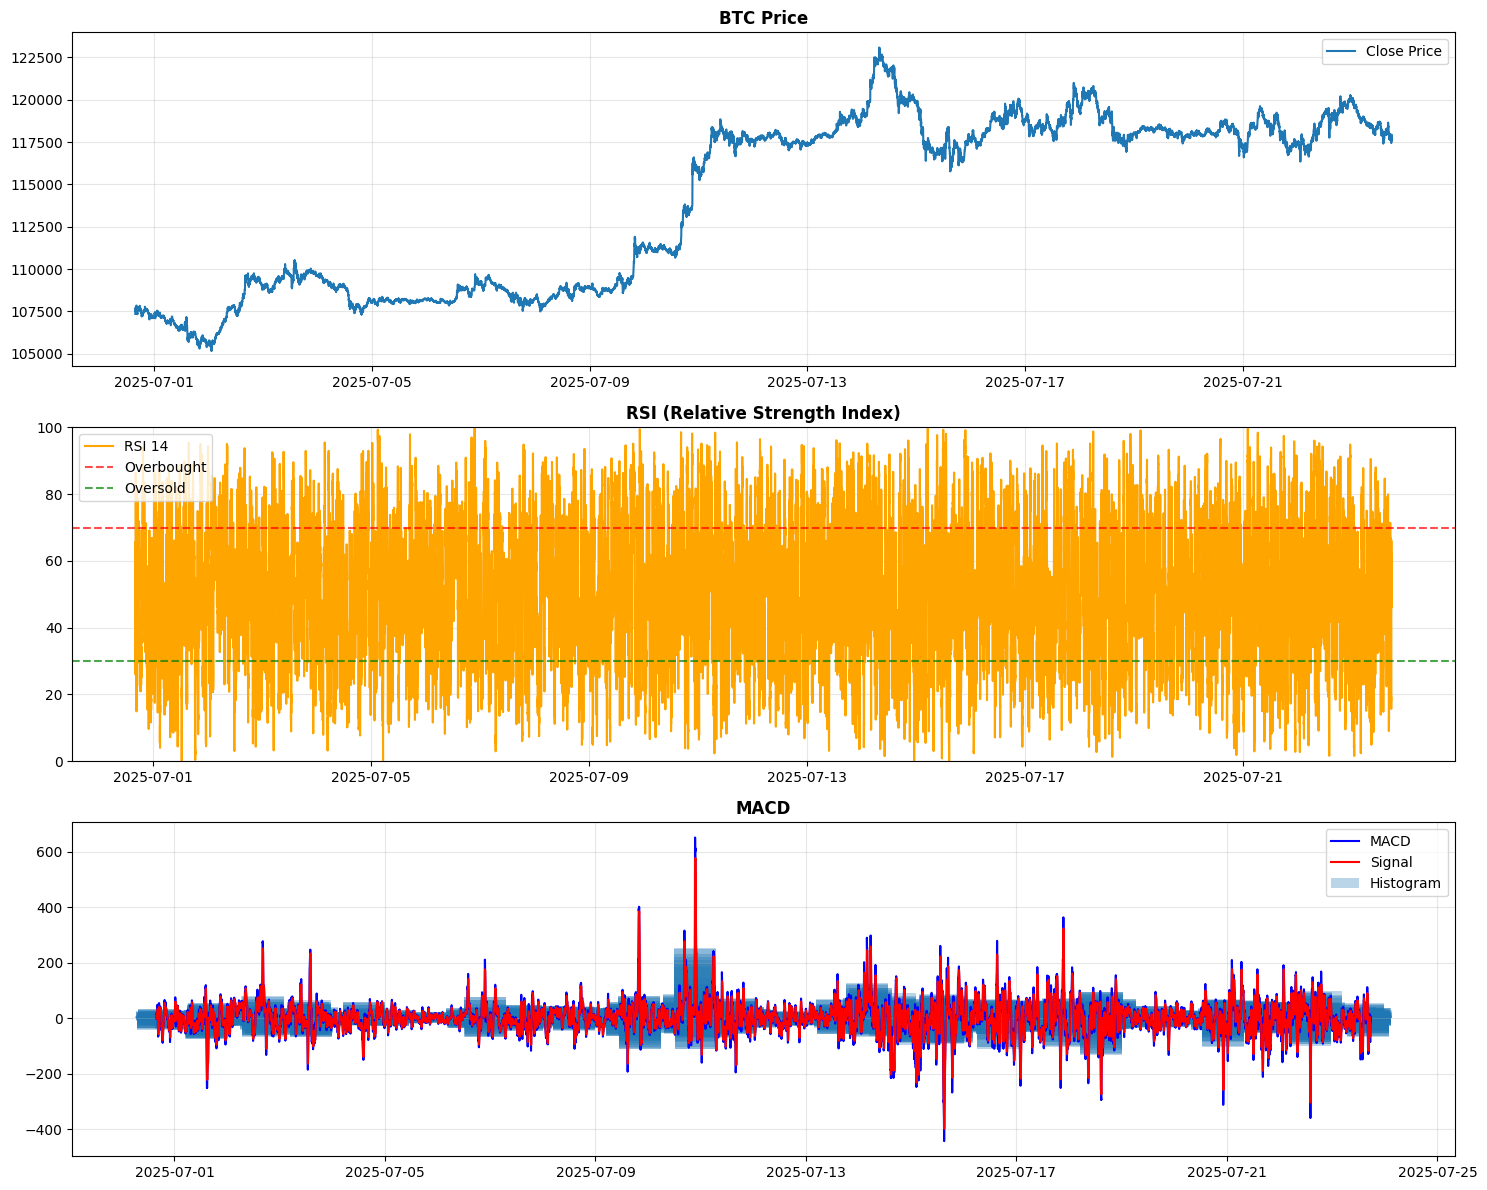


📊 Current Momentum Status:
   RSI: 61.94 (Neutral)
   MACD: 6.50 (Bullish signal)
   Stochastic K: 100.00


In [5]:
# Create Momentum Indicators
print("⚡ Creating Momentum Indicators...")

if TALIB_AVAILABLE:
    try:
        # RSI (Relative Strength Index) - 14 and 21 period
        features_df['RSI_14'] = talib.RSI(features_df['Close'].values, timeperiod=14)
        features_df['RSI_21'] = talib.RSI(features_df['Close'].values, timeperiod=21)
        
        # MACD (Moving Average Convergence Divergence)
        macd, macd_signal, macd_hist = talib.MACD(features_df['Close'].values, 
                                                  fastperiod=12, slowperiod=26, signalperiod=9)
        features_df['MACD'] = macd
        features_df['MACD_Signal'] = macd_signal
        features_df['MACD_Histogram'] = macd_hist
        
        # Stochastic Oscillator
        slowk, slowd = talib.STOCH(features_df['High'].values,
                                   features_df['Low'].values,
                                   features_df['Close'].values,
                                   fastk_period=14, slowk_period=3, slowd_period=3)
        features_df['Stoch_K'] = slowk
        features_df['Stoch_D'] = slowd
        
        # Williams %R
        features_df['Williams_R'] = talib.WILLR(features_df['High'].values,
                                                features_df['Low'].values,
                                                features_df['Close'].values, timeperiod=14)
        
        # ROC (Rate of Change)
        features_df['ROC_10'] = talib.ROC(features_df['Close'].values, timeperiod=10)
        features_df['ROC_20'] = talib.ROC(features_df['Close'].values, timeperiod=20)
        
        print("✅ TAlib indicators created successfully")
        
    except Exception as e:
        print(f"⚠️  TAlib error: {e}, using manual implementations...")
        TALIB_AVAILABLE = False

if not TALIB_AVAILABLE:
    print("⚠️  Using manual indicator implementations...")
    
    # Manual RSI calculation
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    features_df['RSI_14'] = calculate_rsi(features_df['Close'], 14)
    features_df['RSI_21'] = calculate_rsi(features_df['Close'], 21)
    
    # Manual MACD
    ema_12 = features_df['Close'].ewm(span=12).mean()
    ema_26 = features_df['Close'].ewm(span=26).mean()
    features_df['MACD'] = ema_12 - ema_26
    features_df['MACD_Signal'] = features_df['MACD'].ewm(span=9).mean()
    features_df['MACD_Histogram'] = features_df['MACD'] - features_df['MACD_Signal']
    
    # Manual Stochastic
    def calculate_stochastic(high, low, close, window=14):
        lowest_low = low.rolling(window=window).min()
        highest_high = high.rolling(window=window).max()
        k = 100 * ((close - lowest_low) / (highest_high - lowest_low))
        return k
    
    features_df['Stoch_K'] = calculate_stochastic(features_df['High'], features_df['Low'], features_df['Close'])
    features_df['Stoch_D'] = features_df['Stoch_K'].rolling(window=3).mean()
    
    # Manual Williams %R
    def calculate_williams_r(high, low, close, window=14):
        highest_high = high.rolling(window=window).max()
        lowest_low = low.rolling(window=window).min()
        return -100 * ((highest_high - close) / (highest_high - lowest_low))
    
    features_df['Williams_R'] = calculate_williams_r(features_df['High'], features_df['Low'], features_df['Close'])
    
    # ROC (Rate of Change)
    features_df['ROC_10'] = features_df['Close'].pct_change(periods=10) * 100
    features_df['ROC_20'] = features_df['Close'].pct_change(periods=20) * 100
    
    print("✅ Manual indicators created successfully")

# Additional momentum features
features_df['RSI_Overbought'] = (features_df['RSI_14'] > 70).astype(int)
features_df['RSI_Oversold'] = (features_df['RSI_14'] < 30).astype(int)
features_df['MACD_Bullish'] = (features_df['MACD'] > features_df['MACD_Signal']).astype(int)

print(f"✅ Created {len([col for col in features_df.columns if any(ind in col for ind in ['RSI', 'MACD', 'Stoch', 'Williams', 'ROC'])])} momentum indicators")

# Visualize momentum indicators
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Price and MACD
axes[0].plot(features_df['timestamp'], features_df['Close'], label='Close Price')
axes[0].set_title('BTC Price', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RSI
axes[1].plot(features_df['timestamp'], features_df['RSI_14'], label='RSI 14', color='orange')
axes[1].axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought')
axes[1].axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold')
axes[1].set_title('RSI (Relative Strength Index)', fontweight='bold')
axes[1].set_ylim(0, 100)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# MACD
axes[2].plot(features_df['timestamp'], features_df['MACD'], label='MACD', color='blue')
axes[2].plot(features_df['timestamp'], features_df['MACD_Signal'], label='Signal', color='red')
axes[2].bar(features_df['timestamp'], features_df['MACD_Histogram'], label='Histogram', alpha=0.3)
axes[2].set_title('MACD', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Current momentum status
current_rsi = features_df['RSI_14'].iloc[-1]
current_macd = features_df['MACD'].iloc[-1]
current_signal = features_df['MACD_Signal'].iloc[-1]

print(f"\n📊 Current Momentum Status:")
print(f"   RSI: {current_rsi:.2f} ({'Overbought' if current_rsi > 70 else 'Oversold' if current_rsi < 30 else 'Neutral'})")
print(f"   MACD: {current_macd:.2f} ({'Bullish' if current_macd > current_signal else 'Bearish'} signal)")
print(f"   Stochastic K: {features_df['Stoch_K'].iloc[-1]:.2f}")

## 4. Volatility Indicators

Create Bollinger Bands, Average True Range (ATR), and other volatility measures.

📊 Creating Volatility Indicators...
⚠️  Using manual volatility implementations...
✅ Manual volatility indicators created
✅ Created 17 volatility indicators


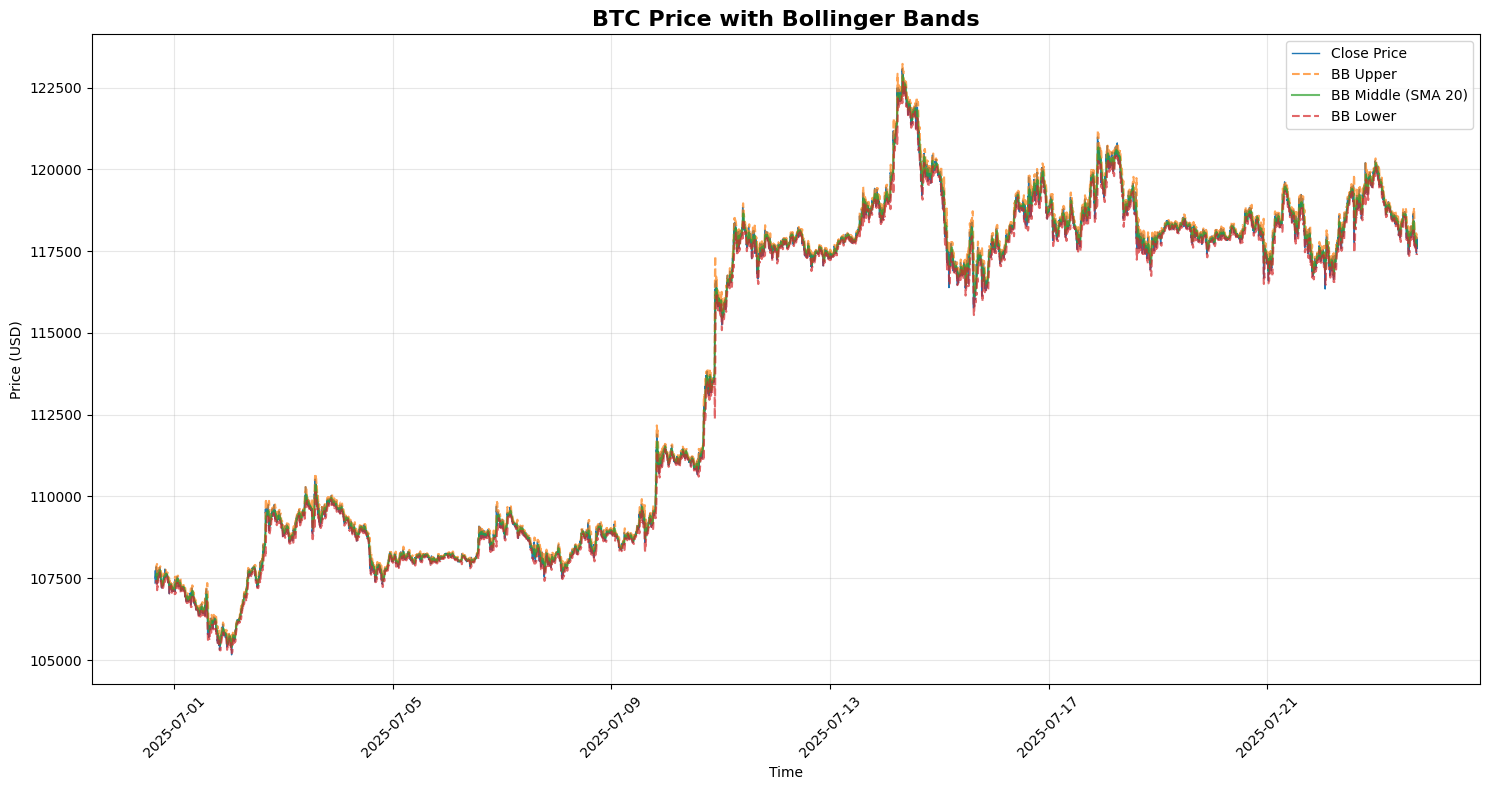


📊 Current Volatility Status:
   Bollinger Band Position: 0.931 (Upper band)
   ATR (14): $90.03
   20-period Volatility: 0.0851%
   Volatility Regime: High


In [6]:
# Create Volatility Indicators
print("📊 Creating Volatility Indicators...")

# Bollinger Bands (20-period with 2 standard deviations)
bb_period = 20
bb_std = 2

features_df['BB_Middle'] = features_df['Close'].rolling(window=bb_period).mean()
bb_std_dev = features_df['Close'].rolling(window=bb_period).std()
features_df['BB_Upper'] = features_df['BB_Middle'] + (bb_std_dev * bb_std)
features_df['BB_Lower'] = features_df['BB_Middle'] - (bb_std_dev * bb_std)

# Bollinger Band indicators
features_df['BB_Width'] = features_df['BB_Upper'] - features_df['BB_Lower']
features_df['BB_Position'] = (features_df['Close'] - features_df['BB_Lower']) / (features_df['BB_Upper'] - features_df['BB_Lower'])
features_df['BB_Squeeze'] = (features_df['BB_Width'] < features_df['BB_Width'].rolling(20).mean()).astype(int)

if TALIB_AVAILABLE:
    try:
        # Average True Range (ATR)
        features_df['ATR_14'] = talib.ATR(features_df['High'].values,
                                          features_df['Low'].values,
                                          features_df['Close'].values, timeperiod=14)
        
        # Commodity Channel Index (CCI)
        features_df['CCI_20'] = talib.CCI(features_df['High'].values,
                                          features_df['Low'].values,
                                          features_df['Close'].values, timeperiod=20)
        
        print("✅ TAlib volatility indicators created")
    except Exception as e:
        print(f"⚠️  TAlib error: {e}, using manual implementations...")
        TALIB_AVAILABLE = False

if not TALIB_AVAILABLE:
    print("⚠️  Using manual volatility implementations...")
    
    # Manual ATR calculation
    def calculate_atr(high, low, close, window=14):
        tr1 = high - low
        tr2 = abs(high - close.shift())
        tr3 = abs(low - close.shift())
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        return tr.rolling(window=window).mean()
    
    features_df['ATR_14'] = calculate_atr(features_df['High'], features_df['Low'], features_df['Close'])
    
    # Manual CCI calculation
    def calculate_cci(high, low, close, window=20):
        tp = (high + low + close) / 3
        ma = tp.rolling(window=window).mean()
        md = tp.rolling(window=window).apply(lambda x: abs(x - x.mean()).mean())
        return (tp - ma) / (0.015 * md)
    
    features_df['CCI_20'] = calculate_cci(features_df['High'], features_df['Low'], features_df['Close'])
    
    print("✅ Manual volatility indicators created")

# Rolling volatility measures
for window in [10, 20, 50]:
    features_df[f'Volatility_{window}'] = features_df['Returns'].rolling(window=window).std()
    features_df[f'Price_Range_{window}'] = (features_df['High'] - features_df['Low']).rolling(window=window).mean()

# Volatility regime indicators
features_df['High_Volatility'] = (features_df['Volatility_20'] > features_df['Volatility_20'].rolling(50).mean()).astype(int)
features_df['ATR_High'] = (features_df['ATR_14'] > features_df['ATR_14'].rolling(20).mean()).astype(int)

print(f"✅ Created {len([col for col in features_df.columns if any(vol in col for vol in ['BB_', 'ATR', 'CCI', 'Volatility', 'Range'])])} volatility indicators")

# Visualize Bollinger Bands
plt.figure(figsize=(15, 8))
plt.plot(features_df['timestamp'], features_df['Close'], label='Close Price', linewidth=1)
plt.plot(features_df['timestamp'], features_df['BB_Upper'], label='BB Upper', alpha=0.7, linestyle='--')
plt.plot(features_df['timestamp'], features_df['BB_Middle'], label='BB Middle (SMA 20)', alpha=0.7)
plt.plot(features_df['timestamp'], features_df['BB_Lower'], label='BB Lower', alpha=0.7, linestyle='--')
plt.fill_between(features_df['timestamp'], features_df['BB_Upper'], features_df['BB_Lower'], alpha=0.1)

plt.title('BTC Price with Bollinger Bands', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Volatility analysis
current_bb_pos = features_df['BB_Position'].iloc[-1]
current_atr = features_df['ATR_14'].iloc[-1]
current_volatility = features_df['Volatility_20'].iloc[-1]

print(f"\n📊 Current Volatility Status:")
print(f"   Bollinger Band Position: {current_bb_pos:.3f} ({'Upper band' if current_bb_pos > 0.8 else 'Lower band' if current_bb_pos < 0.2 else 'Middle range'})")
print(f"   ATR (14): ${current_atr:.2f}")
print(f"   20-period Volatility: {current_volatility*100:.4f}%")
print(f"   Volatility Regime: {'High' if features_df['High_Volatility'].iloc[-1] else 'Normal'}")

## 5. Volume Indicators

Create volume-based indicators like OBV, Volume SMA, and volume patterns.

📊 Creating Volume Indicators...
✅ Created 16 volume indicators


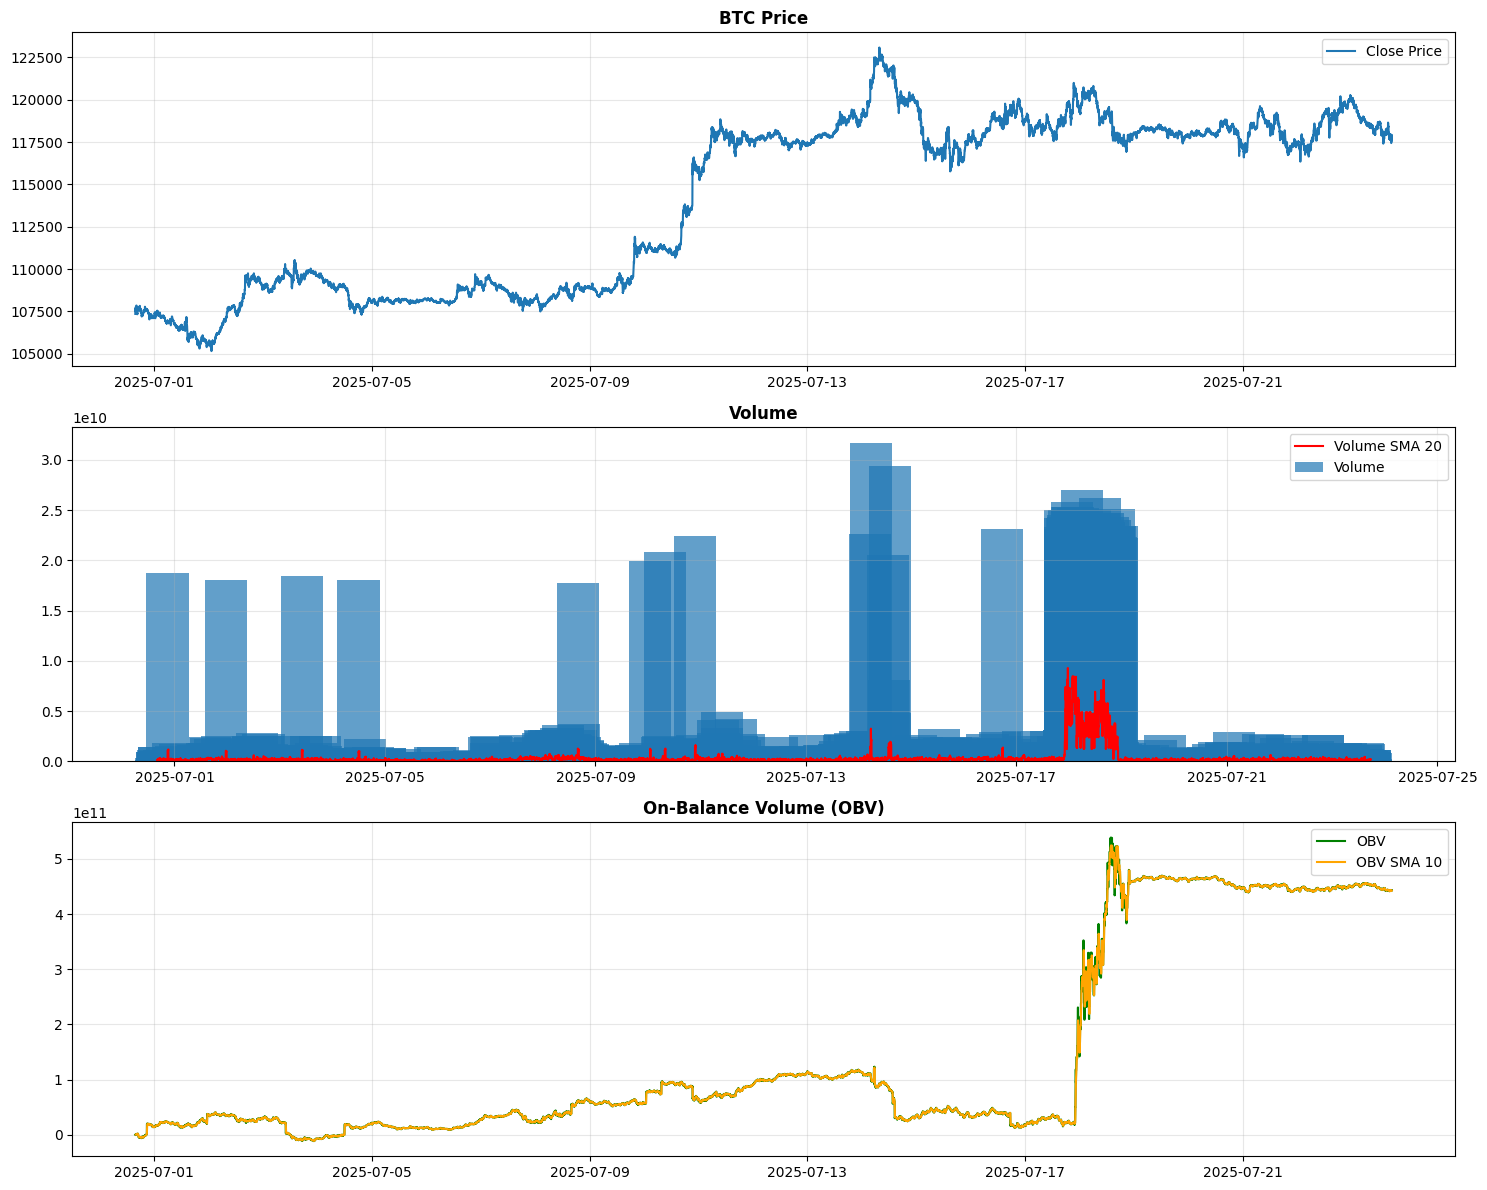


📊 Current Volume Status:
   Volume Ratio (20): 4.42x average
   Volume Trend: High
   Money Flow Index: 46.55 (Neutral)
   Zero Volume Periods: 14421 (51.3%)


In [7]:
# Create Volume Indicators
print("📊 Creating Volume Indicators...")

# Volume Moving Averages
for period in [10, 20, 50]:
    features_df[f'Volume_SMA_{period}'] = features_df['Volume'].rolling(window=period).mean()
    features_df[f'Volume_Ratio_{period}'] = features_df['Volume'] / features_df[f'Volume_SMA_{period}']

# On-Balance Volume (OBV)
def calculate_obv(close, volume):
    obv = []
    obv_val = 0
    
    for i in range(len(close)):
        if i == 0:
            obv_val = volume.iloc[i]
        else:
            if close.iloc[i] > close.iloc[i-1]:
                obv_val += volume.iloc[i]
            elif close.iloc[i] < close.iloc[i-1]:
                obv_val -= volume.iloc[i]
            # If close is unchanged, OBV remains the same
        
        obv.append(obv_val)
    
    return pd.Series(obv, index=close.index)

features_df['OBV'] = calculate_obv(features_df['Close'], features_df['Volume'])
features_df['OBV_SMA_10'] = features_df['OBV'].rolling(window=10).mean()

# Volume Price Trend (VPT)
def calculate_vpt(close, volume):
    vpt = []
    vpt_val = 0
    
    for i in range(len(close)):
        if i == 0:
            vpt_val = volume.iloc[i]
        else:
            price_change = (close.iloc[i] - close.iloc[i-1]) / close.iloc[i-1]
            vpt_val += volume.iloc[i] * price_change
        
        vpt.append(vpt_val)
    
    return pd.Series(vpt, index=close.index)

features_df['VPT'] = calculate_vpt(features_df['Close'], features_df['Volume'])

# Volume indicators
features_df['High_Volume'] = (features_df['Volume'] > features_df['Volume_SMA_20'] * 1.5).astype(int)
features_df['Low_Volume'] = (features_df['Volume'] < features_df['Volume_SMA_20'] * 0.5).astype(int)
features_df['Zero_Volume'] = (features_df['Volume'] == 0).astype(int)

# Price-Volume relationship
features_df['Price_Volume_Trend'] = np.where(
    (features_df['Close'] > features_df['Close'].shift(1)) & (features_df['Volume'] > features_df['Volume_SMA_10']), 1,
    np.where((features_df['Close'] < features_df['Close'].shift(1)) & (features_df['Volume'] > features_df['Volume_SMA_10']), -1, 0)
)

# Volume Rate of Change
features_df['Volume_ROC_10'] = features_df['Volume'].pct_change(periods=10)

try:
    # Money Flow Index (MFI) using TAlib
    features_df['MFI_14'] = talib.MFI(features_df['High'].values,
                                      features_df['Low'].values,
                                      features_df['Close'].values,
                                      features_df['Volume'].values, timeperiod=14)
except:
    # Manual MFI calculation
    def calculate_mfi(high, low, close, volume, window=14):
        typical_price = (high + low + close) / 3
        money_flow = typical_price * volume
        
        positive_flow = []
        negative_flow = []
        
        for i in range(1, len(typical_price)):
            if typical_price.iloc[i] > typical_price.iloc[i-1]:
                positive_flow.append(money_flow.iloc[i])
                negative_flow.append(0)
            elif typical_price.iloc[i] < typical_price.iloc[i-1]:
                positive_flow.append(0)
                negative_flow.append(money_flow.iloc[i])
            else:
                positive_flow.append(0)
                negative_flow.append(0)
        
        positive_flow = [0] + positive_flow
        negative_flow = [0] + negative_flow
        
        positive_mf = pd.Series(positive_flow, index=typical_price.index).rolling(window=window).sum()
        negative_mf = pd.Series(negative_flow, index=typical_price.index).rolling(window=window).sum()
        
        mfi = 100 - (100 / (1 + (positive_mf / negative_mf)))
        return mfi
    
    features_df['MFI_14'] = calculate_mfi(features_df['High'], features_df['Low'], 
                                          features_df['Close'], features_df['Volume'])

print(f"✅ Created {len([col for col in features_df.columns if 'Volume' in col or 'OBV' in col or 'VPT' in col or 'MFI' in col])} volume indicators")

# Visualize volume indicators
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Price
axes[0].plot(features_df['timestamp'], features_df['Close'], label='Close Price')
axes[0].set_title('BTC Price', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volume
axes[1].bar(features_df['timestamp'], features_df['Volume'], alpha=0.7, label='Volume')
axes[1].plot(features_df['timestamp'], features_df['Volume_SMA_20'], label='Volume SMA 20', color='red')
axes[1].set_title('Volume', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# OBV
axes[2].plot(features_df['timestamp'], features_df['OBV'], label='OBV', color='green')
axes[2].plot(features_df['timestamp'], features_df['OBV_SMA_10'], label='OBV SMA 10', color='orange')
axes[2].set_title('On-Balance Volume (OBV)', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Volume analysis
current_volume_ratio = features_df['Volume_Ratio_20'].iloc[-1]
current_mfi = features_df['MFI_14'].iloc[-1]
volume_trend = 'High' if features_df['High_Volume'].iloc[-1] else 'Low' if features_df['Low_Volume'].iloc[-1] else 'Normal'

print(f"\n📊 Current Volume Status:")
print(f"   Volume Ratio (20): {current_volume_ratio:.2f}x average")
print(f"   Volume Trend: {volume_trend}")
print(f"   Money Flow Index: {current_mfi:.2f} ({'Overbought' if current_mfi > 80 else 'Oversold' if current_mfi < 20 else 'Neutral'})")
print(f"   Zero Volume Periods: {features_df['Zero_Volume'].sum()} ({features_df['Zero_Volume'].mean()*100:.1f}%)")

## 6. Time-Based Features

Create temporal features like hour of day, day of week, and cyclical patterns.

⏰ Creating Time-Based Features...
✅ Created 17 time-based features


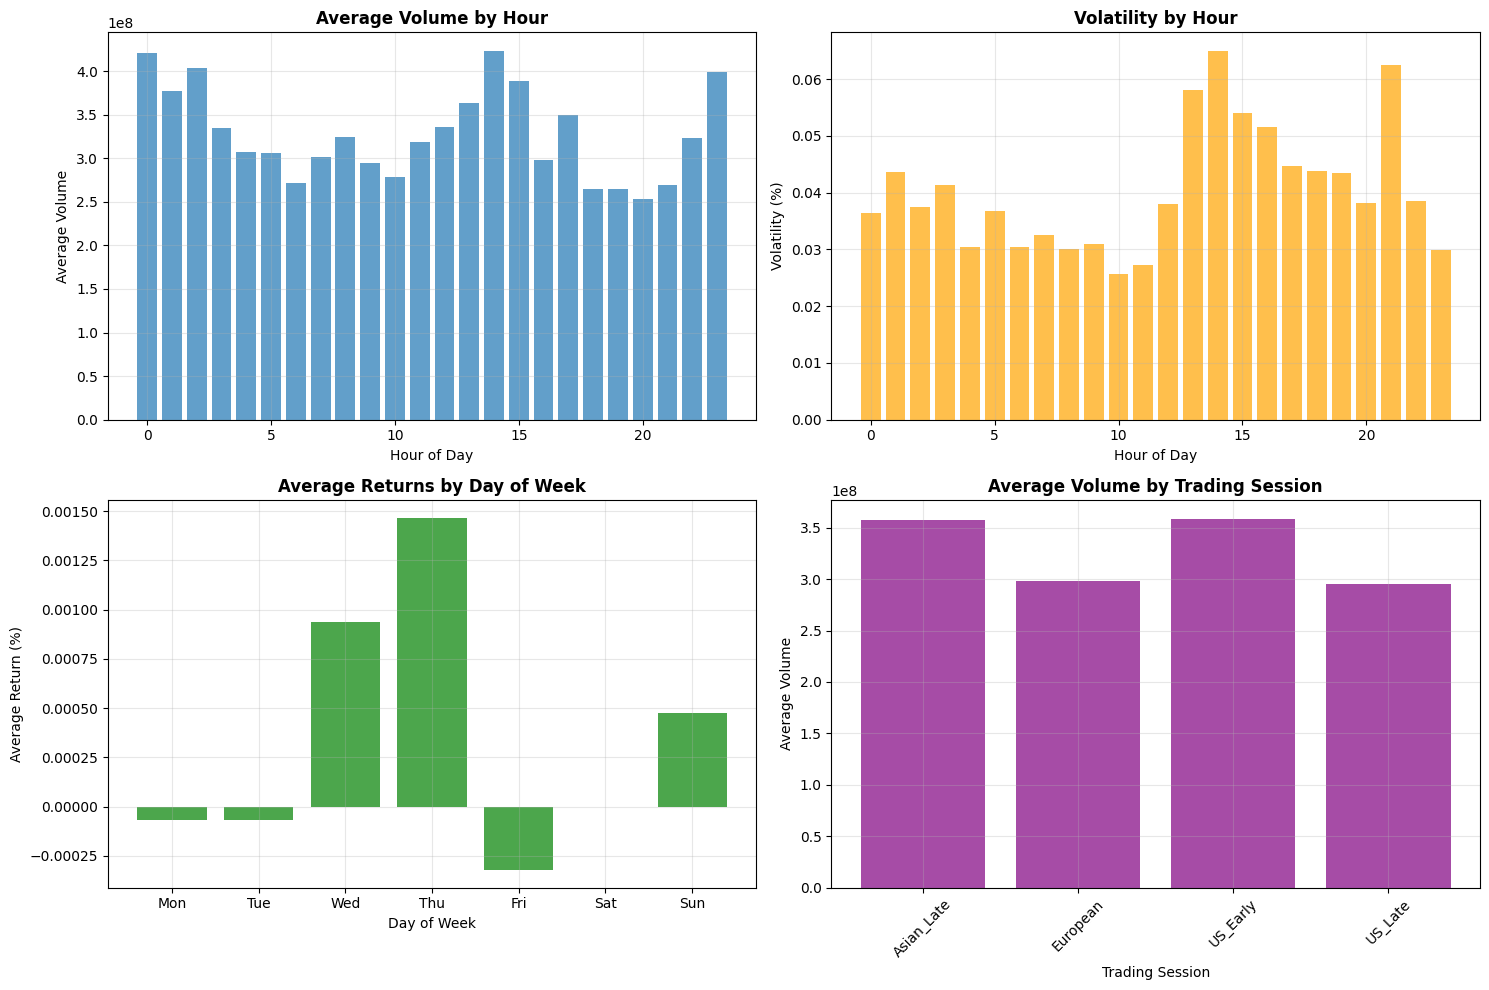


📊 Time Pattern Analysis:
   Most active hour: 14:00 (avg volume: 423,385,739)
   Most volatile hour: 14:00 (0.0650%)
   Best performing day: Thu (0.0015%)
   Most active session: US_Early (avg volume: 358,930,460)


In [8]:
# Create Time-Based Features
print("⏰ Creating Time-Based Features...")

# Basic time features
features_df['Hour'] = features_df['timestamp'].dt.hour
features_df['DayOfWeek'] = features_df['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
features_df['DayOfMonth'] = features_df['timestamp'].dt.day
features_df['IsWeekend'] = (features_df['DayOfWeek'] >= 5).astype(int)

# Cyclical encoding for continuous time features
features_df['Hour_Sin'] = np.sin(2 * np.pi * features_df['Hour'] / 24)
features_df['Hour_Cos'] = np.cos(2 * np.pi * features_df['Hour'] / 24)
features_df['DayOfWeek_Sin'] = np.sin(2 * np.pi * features_df['DayOfWeek'] / 7)
features_df['DayOfWeek_Cos'] = np.cos(2 * np.pi * features_df['DayOfWeek'] / 7)

# Trading session indicators (approximate)
def get_trading_session(hour):
    if 0 <= hour < 6:
        return 'Asian_Late'
    elif 6 <= hour < 12:
        return 'European'
    elif 12 <= hour < 18:
        return 'US_Early'
    else:
        return 'US_Late'

features_df['Trading_Session'] = features_df['Hour'].apply(get_trading_session)

# One-hot encode trading sessions
session_dummies = pd.get_dummies(features_df['Trading_Session'], prefix='Session')
features_df = pd.concat([features_df, session_dummies], axis=1)

# Time-based volatility patterns
hourly_volatility = features_df.groupby('Hour')['Returns'].std()
features_df['Hour_Volatility_Pattern'] = features_df['Hour'].map(hourly_volatility)

# Market activity patterns
features_df['High_Activity_Hour'] = features_df['Hour'].apply(
    lambda x: 1 if x in [8, 9, 13, 14, 15, 16] else 0  # Typical high activity hours
)

# Time since last high/low
def time_since_extreme(prices, window=100):
    rolling_max = prices.rolling(window=window).max()
    rolling_min = prices.rolling(window=window).min()
    
    time_since_high = []
    time_since_low = []
    
    for i in range(len(prices)):
        if i < window:
            time_since_high.append(np.nan)
            time_since_low.append(np.nan)
        else:
            # Find time since last high in the window
            high_val = rolling_max.iloc[i]
            low_val = rolling_min.iloc[i]
            
            window_data = prices.iloc[i-window+1:i+1]
            
            high_indices = window_data[window_data == high_val].index
            low_indices = window_data[window_data == low_val].index
            
            if len(high_indices) > 0:
                last_high_idx = high_indices[-1]
                time_since_high.append(i - (last_high_idx - window_data.index[0]))
            else:
                time_since_high.append(window)
                
            if len(low_indices) > 0:
                last_low_idx = low_indices[-1]
                time_since_low.append(i - (last_low_idx - window_data.index[0]))
            else:
                time_since_low.append(window)
    
    return pd.Series(time_since_high, index=prices.index), pd.Series(time_since_low, index=prices.index)

time_since_high, time_since_low = time_since_extreme(features_df['Close'])
features_df['Time_Since_High'] = time_since_high
features_df['Time_Since_Low'] = time_since_low

print(f"✅ Created {len([col for col in features_df.columns if any(time_feat in col for time_feat in ['Hour', 'Day', 'Weekend', 'Session', 'Activity', 'Time_Since'])])} time-based features")

# Analyze time patterns
plt.figure(figsize=(15, 10))

# Hourly volume pattern
plt.subplot(2, 2, 1)
hourly_volume = features_df.groupby('Hour')['Volume'].mean()
plt.bar(hourly_volume.index, hourly_volume.values, alpha=0.7)
plt.title('Average Volume by Hour', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Average Volume')
plt.grid(True, alpha=0.3)

# Hourly volatility pattern
plt.subplot(2, 2, 2)
plt.bar(hourly_volatility.index, hourly_volatility.values * 100, alpha=0.7, color='orange')
plt.title('Volatility by Hour', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Volatility (%)')
plt.grid(True, alpha=0.3)

# Day of week patterns
plt.subplot(2, 2, 3)
daily_returns = features_df.groupby('DayOfWeek')['Returns'].mean() * 100
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(range(7), daily_returns.values, alpha=0.7, color='green')
plt.title('Average Returns by Day of Week', fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Average Return (%)')
plt.xticks(range(7), days)
plt.grid(True, alpha=0.3)

# Session volume patterns
plt.subplot(2, 2, 4)
session_volume = features_df.groupby('Trading_Session')['Volume'].mean()
plt.bar(session_volume.index, session_volume.values, alpha=0.7, color='purple')
plt.title('Average Volume by Trading Session', fontweight='bold')
plt.xlabel('Trading Session')
plt.ylabel('Average Volume')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Time Pattern Analysis:")
print(f"   Most active hour: {hourly_volume.idxmax()}:00 (avg volume: {hourly_volume.max():,.0f})")
print(f"   Most volatile hour: {hourly_volatility.idxmax()}:00 ({hourly_volatility.max()*100:.4f}%)")
print(f"   Best performing day: {days[daily_returns.idxmax()]} ({daily_returns.max():.4f}%)")
print(f"   Most active session: {session_volume.idxmax()} (avg volume: {session_volume.max():,.0f})")

## 7. Feature Summary and Export

Summarize all created features and save the enhanced dataset for ML modeling.

📋 FEATURE ENGINEERING SUMMARY
📊 FEATURE CATEGORIES:
   Original Features: 8
   Moving Averages: 36
   Momentum Indicators: 14
   Volatility Measures: 18
   Volume Indicators: 16
   Time-Based Features: 17
   Other Features: 3
   TOTAL FEATURES: 102

🔍 FEATURE CORRELATION ANALYSIS:


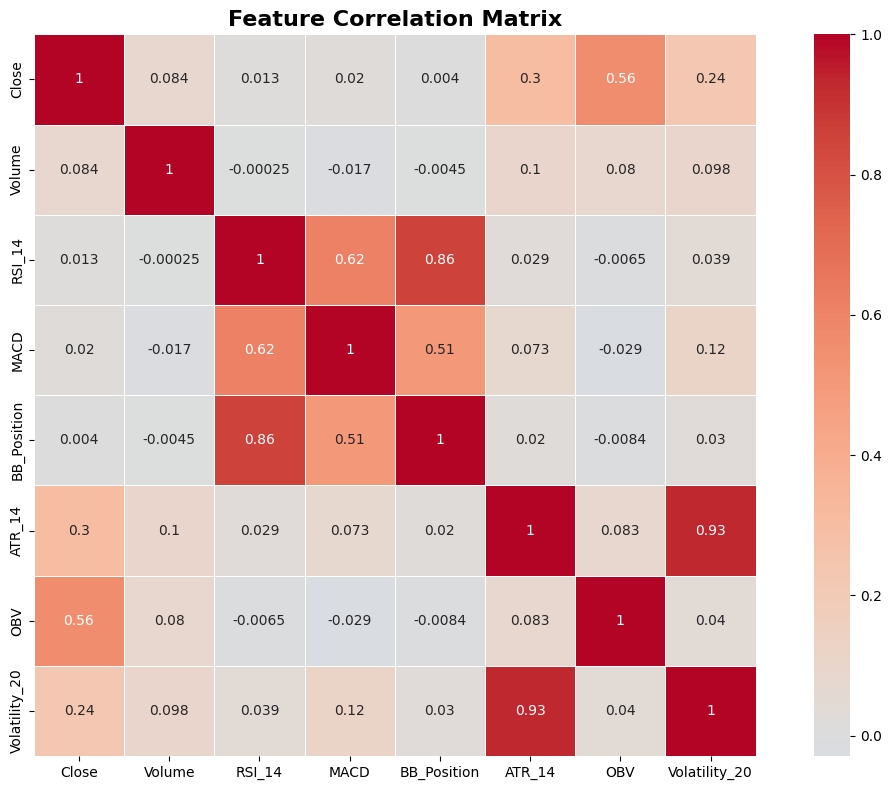

   High correlations (>0.8):
     RSI_14 ↔ BB_Position: 0.859
     ATR_14 ↔ Volatility_20: 0.931

🔍 DATA QUALITY CHECK:
   Features with missing values:
     Returns: 1 (0.00%)
     VWAP: 1 (0.00%)
     data_type: 99 (0.35%)
     SMA_5: 4 (0.01%)
     Price_SMA_5_Ratio: 4 (0.01%)
     SMA_10: 9 (0.03%)
     Price_SMA_10_Ratio: 9 (0.03%)
     SMA_20: 19 (0.07%)
     Price_SMA_20_Ratio: 19 (0.07%)
     SMA_50: 49 (0.17%)
     Price_SMA_50_Ratio: 49 (0.17%)
     SMA_100: 99 (0.35%)
     Price_SMA_100_Ratio: 99 (0.35%)
     SMA_200: 199 (0.71%)
     Price_SMA_200_Ratio: 199 (0.71%)
     SMA_5_20_Diff: 19 (0.07%)
     RSI_14: 13 (0.05%)
     RSI_21: 20 (0.07%)
     Stoch_K: 13 (0.05%)
     Stoch_D: 15 (0.05%)
     Williams_R: 13 (0.05%)
     ROC_10: 10 (0.04%)
     ROC_20: 20 (0.07%)
     BB_Middle: 19 (0.07%)
     BB_Upper: 19 (0.07%)
     BB_Lower: 19 (0.07%)
     BB_Width: 19 (0.07%)
     BB_Position: 19 (0.07%)
     ATR_14: 13 (0.05%)
     CCI_20: 19 (0.07%)
     Volatility_10: 10 (0.04

In [9]:
# Feature Summary and Export
print("📋 FEATURE ENGINEERING SUMMARY")
print("=" * 60)

# Categorize features
original_features = ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
moving_avg_features = [col for col in features_df.columns if any(ma in col for ma in ['SMA', 'EMA', 'Cross', 'Diff', 'Ratio'])]
momentum_features = [col for col in features_df.columns if any(mom in col for mom in ['RSI', 'MACD', 'Stoch', 'Williams', 'ROC'])]
volatility_features = [col for col in features_df.columns if any(vol in col for vol in ['BB_', 'ATR', 'CCI', 'Volatility', 'Range'])]
volume_features = [col for col in features_df.columns if any(vol in col for vol in ['Volume', 'OBV', 'VPT', 'MFI']) and 'Volatility' not in col]
time_features = [col for col in features_df.columns if any(time_feat in col for time_feat in ['Hour', 'Day', 'Weekend', 'Session', 'Activity', 'Time_Since'])]
other_features = [col for col in features_df.columns if col not in original_features + moving_avg_features + momentum_features + volatility_features + volume_features + time_features]

print(f"📊 FEATURE CATEGORIES:")
print(f"   Original Features: {len(original_features)}")
print(f"   Moving Averages: {len(moving_avg_features)}")
print(f"   Momentum Indicators: {len(momentum_features)}")
print(f"   Volatility Measures: {len(volatility_features)}")
print(f"   Volume Indicators: {len(volume_features)}")
print(f"   Time-Based Features: {len(time_features)}")
print(f"   Other Features: {len(other_features)}")
print(f"   TOTAL FEATURES: {len(features_df.columns)}")

# Feature correlation analysis
print(f"\n🔍 FEATURE CORRELATION ANALYSIS:")

# Select key features for correlation analysis
key_features = ['Close', 'Volume', 'RSI_14', 'MACD', 'BB_Position', 'ATR_14', 'OBV', 'Volatility_20']
key_features = [f for f in key_features if f in features_df.columns]

if len(key_features) > 1:
    correlation_matrix = features_df[key_features].corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5)
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated features
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.8:
                high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))
    
    if high_corr_pairs:
        print(f"   High correlations (>0.8):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"     {feat1} ↔ {feat2}: {corr:.3f}")
    else:
        print(f"   ✅ No highly correlated features found")

# Data quality check
print(f"\n🔍 DATA QUALITY CHECK:")
missing_counts = features_df.isnull().sum()
features_with_missing = missing_counts[missing_counts > 0]

if len(features_with_missing) > 0:
    print(f"   Features with missing values:")
    for feature, count in features_with_missing.items():
        pct = (count / len(features_df)) * 100
        print(f"     {feature}: {count} ({pct:.2f}%)")
else:
    print(f"   ✅ No missing values in engineered features")

# Feature importance preview (simple correlation with future returns)
future_periods = [1, 5, 10, 30]  # minutes ahead
returns_features = []

for period in future_periods:
    col_name = f'Future_Return_{period}m'
    features_df[col_name] = features_df['Close'].pct_change(periods=period).shift(-period)
    returns_features.append(col_name)

print(f"\n📈 FEATURE IMPORTANCE PREVIEW:")
numeric_features = features_df.select_dtypes(include=[np.number]).columns
numeric_features = [f for f in numeric_features if f not in returns_features + ['timestamp']]

if len(numeric_features) > 10:  # Only if we have enough features
    for period in [1, 5, 10]:
        target_col = f'Future_Return_{period}m'
        if target_col in features_df.columns:
            correlations = features_df[numeric_features].corrwith(features_df[target_col]).abs().sort_values(ascending=False)
            top_features = correlations.head(10)
            
            print(f"\n   Top features for {period}-minute prediction:")
            for feature, corr in top_features.items():
                if not pd.isna(corr):
                    print(f"     {feature}: {corr:.4f}")

# Save enhanced dataset
output_path = '../data/BTCUSD_minute_features.csv'
try:
    # Drop the future return columns before saving (they were just for analysis)
    features_to_save = features_df.drop(columns=returns_features)
    features_to_save.to_csv(output_path, index=False)
    print(f"\n💾 DATASET SAVED:")
    print(f"   File: {output_path}")
    print(f"   Shape: {features_to_save.shape}")
    print(f"   Size: {features_to_save.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except:
    print(f"\n⚠️  Could not save to {output_path}, trying alternative path...")
    output_path = 'BTCUSD_minute_features.csv'
    features_to_save = features_df.drop(columns=returns_features)
    features_to_save.to_csv(output_path, index=False)
    print(f"   Saved to: {output_path}")

print(f"\n🎯 NEXT STEPS:")
print(f"   1. Use features_df for ML model training")
print(f"   2. Consider feature selection techniques")
print(f"   3. Implement proper train/validation/test splits")
print(f"   4. Try different ML algorithms (Random Forest, XGBoost, Neural Networks)")
print(f"   5. Backtest trading strategies based on predictions")

# Feature list for reference
print(f"\n📝 COMPLETE FEATURE LIST:")
feature_categories = {
    'Original': original_features,
    'Moving Averages': moving_avg_features,
    'Momentum': momentum_features,
    'Volatility': volatility_features,
    'Volume': volume_features,
    'Time-Based': time_features,
    'Other': other_features
}

for category, features in feature_categories.items():
    if features:
        print(f"\n   {category} ({len(features)}):")
        for feature in sorted(features):
            print(f"     - {feature}")

print(f"\n🎉 Feature engineering completed successfully!")
print(f"   Original columns: {len(original_features)}")
print(f"   New features created: {len(features_df.columns) - len(original_features)}")
print(f"   Total features: {len(features_df.columns)}")